# Alignment from foundation models' embeddings

Before running tutorials, make sure you've obtained DRIFT-enhanced embeddings for the source and target data

In [3]:
import sys
# sys.path.append("..")   # add parent dir so alignment_code is visible


import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from src.align import *


In [ ]:
#need to install pycpd

## Input target and source embedding files here


In [5]:

target_embedding_path = f"./data/adata_028_A1_filtered_embedding_Diffusion_10.0.h5ad"
source_embedding_path =  f"./data/adata_028_C1_filtered_embedding_Diffusion_10.0.h5ad"


In [6]:
import scanpy as sc
target_embedding_adata = sc.read_h5ad(target_embedding_path)
target_coordinates = target_embedding_adata.obsm['spatial']

source_embedding_adata = sc.read_h5ad(source_embedding_path)
source_coordinates = source_embedding_adata.obsm['spatial']


In [10]:
tar_features = pd.DataFrame(target_embedding_adata.X.T)
src_features = pd.DataFrame(source_embedding_adata.X.T)
pca_comb_features = get_pca_by_fit(tar_features, src_features)
pca_rgb_comb, pca_hex_comb = pca_to_hex_colors(pca_comb_features)



In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Pick the label column here:
label_key = "ground_truth"  

labels_tar = target_embedding_adata.obs[label_key].astype(str).values
labels_src = source_embedding_adata.obs[label_key].astype(str).values

# Build a consistent colormap
unique_labels = np.unique(np.concatenate([labels_tar, labels_src]))
cmap = plt.get_cmap("tab20")  
label_to_color = {lab: cmap(i % 20) for i, lab in enumerate(unique_labels)}

colors_tar = [label_to_color[l] for l in labels_tar]
colors_src = [label_to_color[l] for l in labels_src]


## Visualization of the slices before alignment 

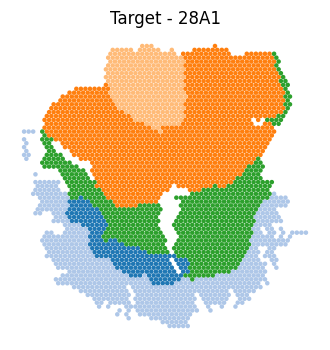

In [13]:

plt.figure(figsize=(4,4))
plt.scatter(target_coordinates[:,0], target_coordinates[:,1], marker='o', s=5, c=colors_tar)
plt.axis('off')
plt.title('Target - 28A1')
plt.show()

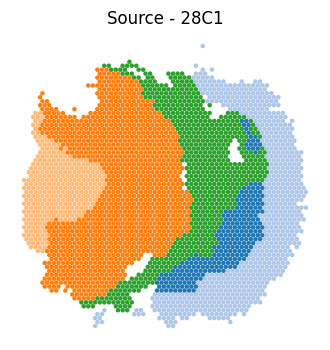

In [22]:
plt.figure(figsize=(4,4))
plt.scatter(source_coordinates[:,0], source_coordinates[:,1], marker='o', s=5, c=colors_src)
plt.axis('off')
plt.title('Source - 28C1')
plt.show()

## Running alignment

In [15]:
###running alignment with CPD

new_non_rigid_coordinates, new_rigid_coordinates = align_tissue(target_coordinates,                         
                                                                      source_coordinates, pca_comb_features)


## Visualization of the aligned slices

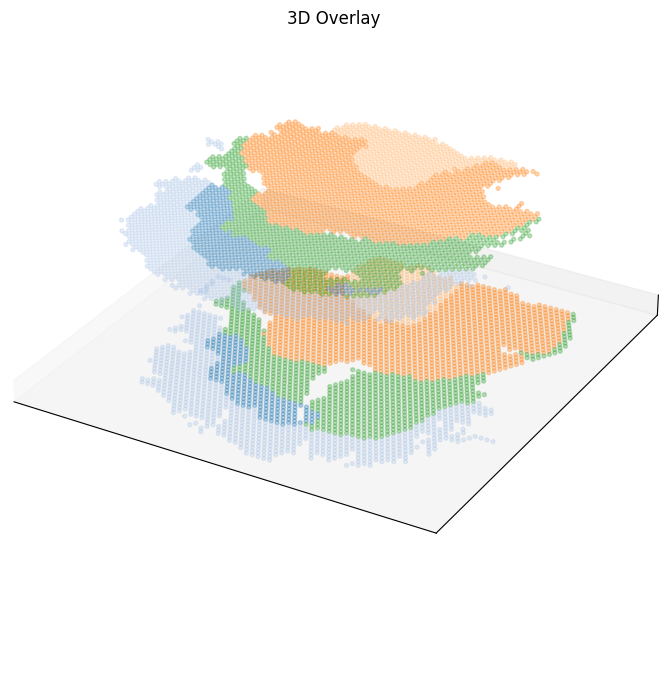

In [16]:
###visualization of alignments in 3D

from mpl_toolkits.mplot3d import Axes3D

# Small separation so they appear on top of each other
z_tar = np.zeros(len(target_coordinates))
z_src = np.ones(len(new_rigid_coordinates)) * 0.2

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111, projection='3d')

# Target ground-truth
ax.scatter(
    target_coordinates[:,0],
    target_coordinates[:,1],
    z_tar,
    c=colors_tar,
    s=8,
    alpha=0.3,
    label="Target"
)

# Aligned source ground-truth
ax.scatter(
    new_rigid_coordinates[:,0],
    new_rigid_coordinates[:,1],
    z_src,
    c=colors_src,
    s=8,
    alpha=0.3,
    label="Aligned Source"
)

ax.set_title("3D Overlay")
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

# Flatten z-axis so the layers look close
ax.set_zlim(0, 0.03)
ax.set_box_aspect([1, 1, 0.05])

plt.tight_layout()
plt.show()


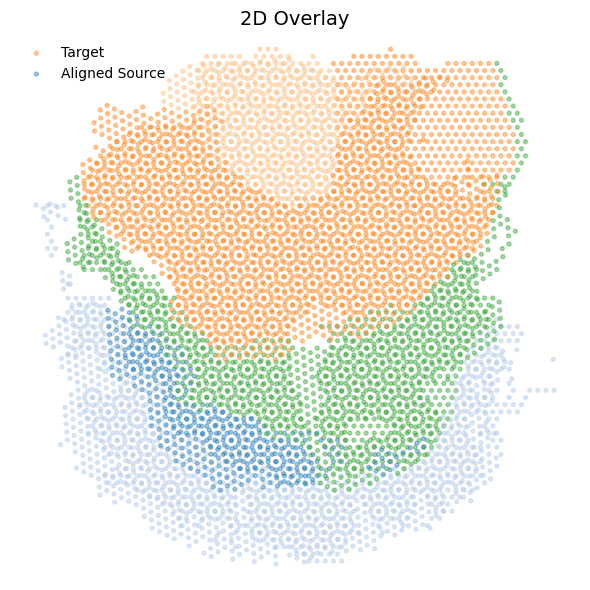

In [17]:
###visualization of overlaps in 2D
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))

# Target (true)
plt.scatter(
    target_coordinates[:,0],
    target_coordinates[:,1],
    c=colors_tar,
    s=8,
    alpha=0.40,
    label="Target"
)

# Aligned source (predicted)
plt.scatter(
    new_rigid_coordinates[:,0],
    new_rigid_coordinates[:,1],
    c=colors_src,
    s=8,
    alpha=0.40,
    label="Aligned Source"
)

plt.title("2D Overlay", fontsize=14)
plt.axis("equal")
plt.xticks([]); plt.yticks([])
for sp in plt.gca().spines.values(): 
    sp.set_visible(False)

plt.legend(frameon=False)
plt.tight_layout()
plt.show()
